In [1]:
import os
try:
    os.chdir(os.path.join(os.getcwd(), '..'))
    print(os.getcwd())
except Exception as ex:
    print(ex) 

/home/dima/UCU/ResponsibleDataScience/Repos/resp-ds-2019


In [2]:
from models.gender_classification.gender_classification import GenderClassifier
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.util.image_ops import load_image, show_image, normalize, add_noise, flip_pixels, image_transformation
from skater.util.logger import build_logger, _INFO
from skater.core.visualizer.image_relevance_visualizer import visualize
from scipy.misc import imresize, imsave
import tensorflow as tf
from keras import backend as K
import cv2
import numpy as np

Using TensorFlow backend.


In [3]:
IMAGE_PATH = "models/gender_classification/predict_data_test/1.jpg"
MODEL_PATH = "models/gender_classification/gender_classification.model"

In [4]:
gender_classifier = GenderClassifier(model_path=MODEL_PATH)
image = gender_classifier.preprocess_image(image_path=IMAGE_PATH)
label = gender_classifier.predict_by_image(image=image)
img_sizes = gender_classifier.IMAGE_SIZES
model = gender_classifier.get_model()
squeezed_image = (np.squeeze(image))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [5]:
def image_resizing(img_file):
    img_as_arry = img_to_array(img_file)
    resized = imresize(img_as_arry, (img_sizes[0], img_sizes[1]))
    an_img = resized.reshape((1,) + resized.shape)
    return an_img

In [6]:
show_image(squeezed_image)
img_resized = image_resizing(squeezed_image)
print(img_resized.shape)
label

(1, 96, 96, 3)


'woman'

In [7]:
inverted_color_img = image_transformation(squeezed_image, method_type='invert')
show_image(inverted_color_img, title='Color Inverted')
inverted_color_img = image_resizing(inverted_color_img)

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    K.set_session(sess)
    input_x = np.array([img_resized[0], inverted_color_img[0]])
    K.set_learning_phase(0)
    with DeepInterpreter(session=K.get_session()) as di:
        di.logger = build_logger(_INFO, __name__)
        X = model.layers[0].input
        output_tensor = model.layers[-2].output

        # 3. We will using the last dense layer(pre-softmax) as the output layer
        xs = input_x
        print("X shape: {}".format(xs.shape))

        # Predicted Labels
#         predictions = map(lambda x: model.predict_classes(x.reshape((1,) + x.shape)) , input_x)
#         labels = map(lambda x: "man" if x==1 else "woman", predictions)
#         print("Predicted class Label: {}".format(list(labels)))

        # compute the relevance score
        # Computing relevance or attribution by perturbing the feature space using occlusion is computationally expensive
        # One might need to control the rolling window parameters (Height, Width, stepsize) manage computational resource
        # optional args for occlusion
        optional_args = {"window_size": 2, "step": 2}
        relevance_scores = {
            'integrated gradient': di.explain('ig', output_tensor, X, xs, use_case='image'),
            'e-LRP': di.explain('elrp', output_tensor, X, xs, use_case='image'),
            'occlusion': di.explain('occlusion', output_tensor, X, xs, use_case='image', **optional_args)
        }

2019-05-14 18:58:47,095 - __main__ - INFO - all supported relevancy scorers OrderedDict([('elrp', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP'>}), ('ig', {'use_case_type': ['image', 'txt'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients'>}), ('occlusion', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.perturbation_relevance_scorer.Occlusion'>})])
2019-05-14 18:58:47,096 - __main__ - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients'>
2019-05-14 18:58:47,096 - __main__ - INFO - DeepInterpreter: executing method <skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients object at 0x7fe6b5317e10>
2019-05-14 18:58:47,096 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrate

X shape: (2, 96, 96, 3)


2019-05-14 18:58:51,921 - __main__ - INFO - all supported relevancy scorers OrderedDict([('elrp', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP'>}), ('ig', {'use_case_type': ['image', 'txt'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients'>}), ('occlusion', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.perturbation_relevance_scorer.Occlusion'>})])
2019-05-14 18:58:51,921 - __main__ - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP'>
2019-05-14 18:58:51,922 - LRP - INFO - Epsilon value: 0.0001
2019-05-14 18:58:51,922 - __main__ - INFO - DeepInterpreter: executing method <skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP object at 0x7fe6b5317e10>
2019-05-14 18:58:51,922 - BaseGradientMethod - INFO - Executing operations ...
2019

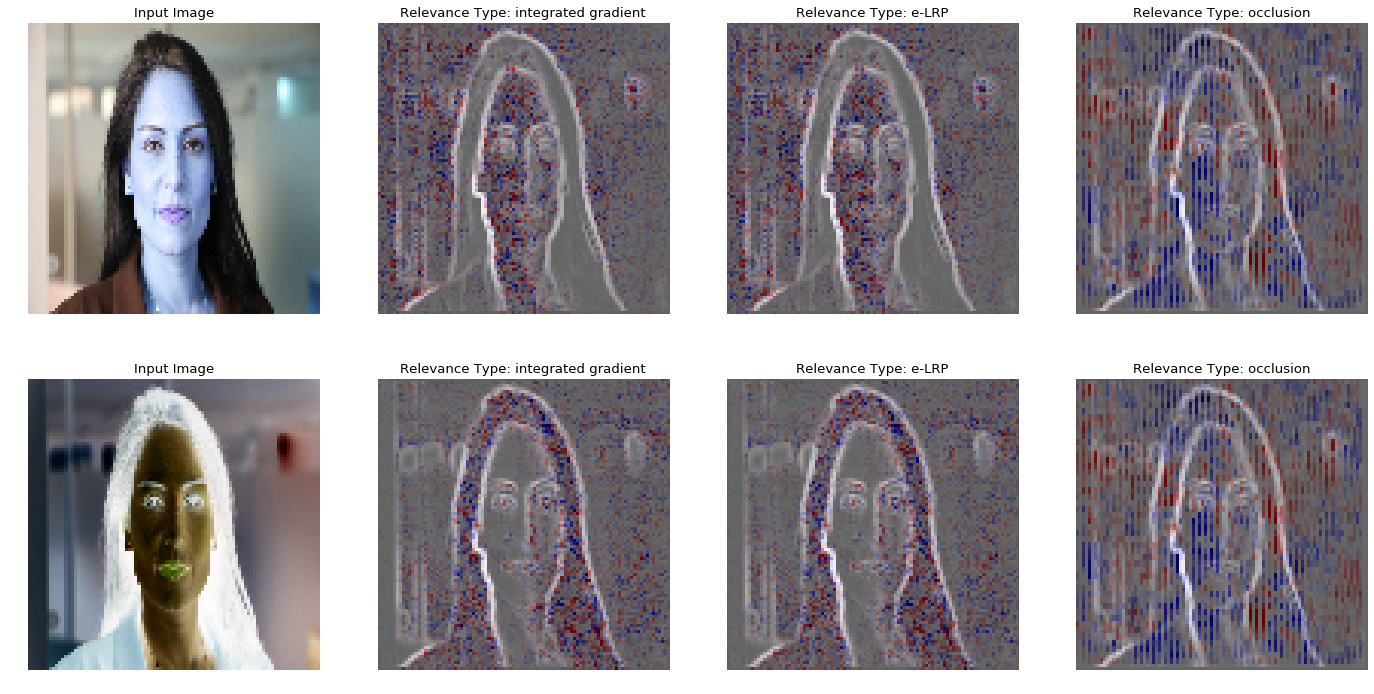

In [11]:
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 11

xs = input_x
n_cols = int(len(relevance_scores)) + 1
n_rows = len(input_x) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Input Image')
    ax.axis('off')
    for j, r_type in enumerate(relevance_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevance_scores[r_type][i], original_input_img=xi, axis=axj, 
                  percentile=99, alpha_edges=1, alpha_bgcolor=0.4).set_title("Relevance Type: {}".format(r_type))

In [12]:
IMAGE_PATH = "models/gender_classification/predict_data_test/2.jpg"

In [13]:
image = gender_classifier.preprocess_image(image_path=IMAGE_PATH)
squeezed_image = (np.squeeze(image))

(1, 96, 96, 3)


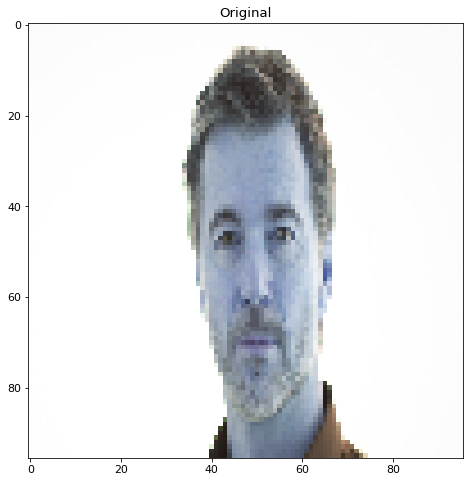

In [15]:
show_image(squeezed_image)
img_resized = image_resizing(squeezed_image)
print(img_resized.shape)

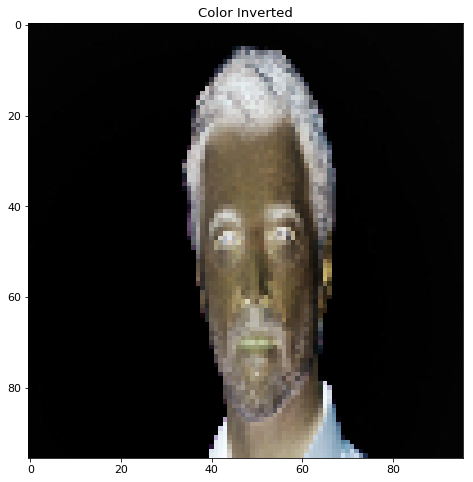

In [16]:
inverted_color_img = image_transformation(squeezed_image, method_type='invert')
show_image(inverted_color_img, title='Color Inverted')
inverted_color_img = image_resizing(inverted_color_img)

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    K.set_session(sess)
    input_x = np.array([img_resized[0], inverted_color_img[0]])
    K.set_learning_phase(0)
    with DeepInterpreter(session=K.get_session()) as di:
        di.logger = build_logger(_INFO, __name__)
        X = model.layers[0].input
        output_tensor = model.layers[-2].output

        # 3. We will using the last dense layer(pre-softmax) as the output layer
        xs = input_x
        print("X shape: {}".format(xs.shape))

        # Predicted Labels
#         predictions = map(lambda x: model.predict_classes(x.reshape((1,) + x.shape)) , input_x)
#         labels = map(lambda x: "man" if x==1 else "woman", predictions)
#         print("Predicted class Label: {}".format(list(labels)))

        # compute the relevance score
        # Computing relevance or attribution by perturbing the feature space using occlusion is computationally expensive
        # One might need to control the rolling window parameters (Height, Width, stepsize) manage computational resource
        # optional args for occlusion
        optional_args = {"window_size": 2, "step": 2}
        relevance_scores = {
            'integrated gradient': di.explain('ig', output_tensor, X, xs, use_case='image'),
            'e-LRP': di.explain('elrp', output_tensor, X, xs, use_case='image'),
            'occlusion': di.explain('occlusion', output_tensor, X, xs, use_case='image', **optional_args)
        }

2019-05-14 19:01:07,410 - __main__ - INFO - all supported relevancy scorers OrderedDict([('elrp', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP'>}), ('ig', {'use_case_type': ['image', 'txt'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients'>}), ('occlusion', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.perturbation_relevance_scorer.Occlusion'>})])
2019-05-14 19:01:07,410 - __main__ - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients'>
2019-05-14 19:01:07,410 - __main__ - INFO - DeepInterpreter: executing method <skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients object at 0x7fe6a7e22198>
2019-05-14 19:01:07,411 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrate

X shape: (2, 96, 96, 3)


2019-05-14 19:01:12,399 - __main__ - INFO - all supported relevancy scorers OrderedDict([('elrp', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP'>}), ('ig', {'use_case_type': ['image', 'txt'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients'>}), ('occlusion', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.perturbation_relevance_scorer.Occlusion'>})])
2019-05-14 19:01:12,400 - __main__ - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP'>
2019-05-14 19:01:12,400 - LRP - INFO - Epsilon value: 0.0001
2019-05-14 19:01:12,401 - __main__ - INFO - DeepInterpreter: executing method <skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP object at 0x7fe6a621b898>
2019-05-14 19:01:12,402 - BaseGradientMethod - INFO - Executing operations ...
2019

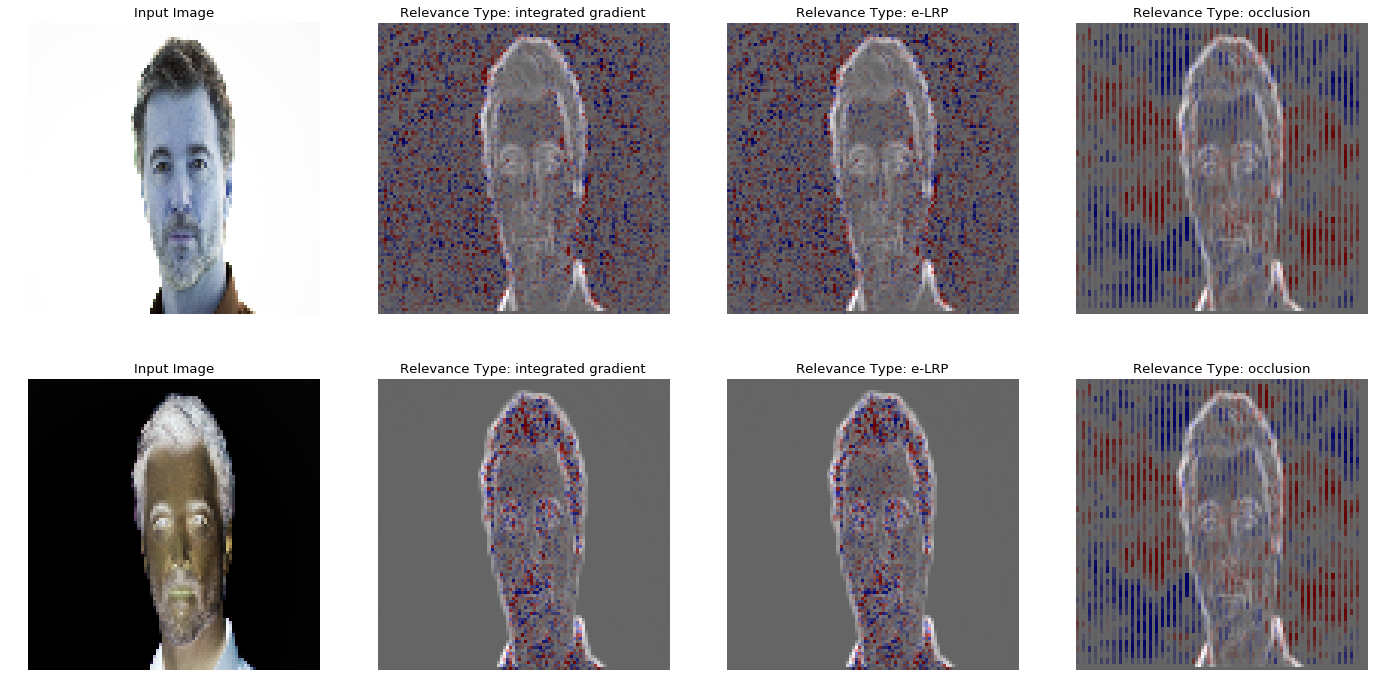

In [18]:
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 11

xs = input_x
n_cols = int(len(relevance_scores)) + 1
n_rows = len(input_x) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Input Image')
    ax.axis('off')
    for j, r_type in enumerate(relevance_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevance_scores[r_type][i], original_input_img=xi, axis=axj, 
                  percentile=99, alpha_edges=1, alpha_bgcolor=0.4).set_title("Relevance Type: {}".format(r_type))